In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
import warnings
 
warnings.filterwarnings("ignore")


In [2]:
# 재생산성을 위해 시드 고정
np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)


In [14]:
def trainGenerator():
    
    train_path = 'train'
    train_files = sorted(glob.glob(train_path + '/*'))
    
    for file in train_files:
        
        dataset = np.load(file)
        
        target= dataset[:,:,-1].reshape(40,40,1)
        cutoff_labels = np.where(target < 0, 0, target)
        feature = dataset[:,:,:10]    
        
        if (cutoff_labels > 0).sum() < 50:
            
            continue

        yield (feature, cutoff_labels)
        
train_dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([40,40,10]),tf.TensorShape([40,40,1])))

In [15]:
train_dataset = train_dataset.batch(512).prefetch(1)

In [16]:
test_path = 'test'
test_files = sorted(glob.glob(test_path + '/*'))

X_test = []

for file in tqdm(test_files, desc = 'test'):
    
    data = np.load(file)
    
    X_test.append(data[:,:,:10])
                  
X_test = np.array(X_test)


test: 100%|██████████| 2416/2416 [00:06<00:00, 379.07it/s]


### Exploratory Data Analysis

In [6]:
import seaborn as sns
color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()
image_sample = np.load('train/subset_010462_02.npy')

Let us plot the precipitation 

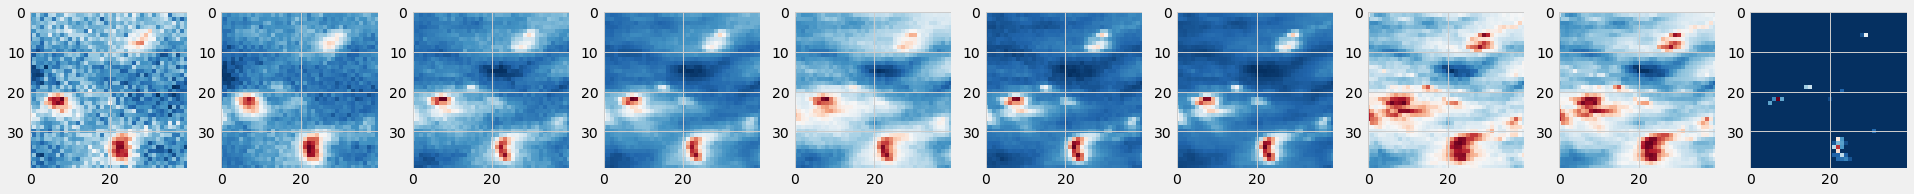

In [7]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(30, 30))

for i in range(9):
    plt.subplot(1,10,i+1)
    plt.imshow(image_sample[:, :, i], cmap=color_map)

plt.subplot(1,10,10)
plt.imshow(image_sample[:,:,-1], cmap = color_map)
plt.show()


### Create UNet Model  

In [17]:
def build_model(input_layer, start_neurons):
    
    # 40 x 40 -> 20 x 20
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(pool1)
    pool1 = Dropout(0.25)(pool1)

    # 20 x 20 -> 10 x 10
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(pool2)
    pool2 = Dropout(0.25)(pool2)

    # 10 x 10 
    convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)

    # 10 x 10 -> 20 x 20
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.25)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    # 20 x 20 -> 40 x 40
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.25)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Dropout(0.25)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation='relu')(uconv1)
    
    return output_layer

input_layer = Input((40, 40, 10))
output_layer = build_model(input_layer, 32)

In [18]:
model = Model(input_layer, output_layer)

In [19]:
from sklearn.metrics import f1_score

def mae(y_true, y_pred) :
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    over_threshold = y_true >= 0.1
    
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    remove_NAs = y_true >= 0
    
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def maeOverFscore_keras(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

In [20]:
model.compile(loss="mae", optimizer="adam", metrics=[maeOverFscore_keras, fscore_keras])

In [21]:
# let's train the model 
model_history = model.fit(train_dataset, epochs = 18, verbose=1) 
print("Saving........") 
model.save('UNET_weak18.h5')

Epoch 1/18
61/61 [==============================] - 1084s 18s/step - loss: 0.3735 - maeOverFscore_keras: 4.3674 - fscore_keras: 0.4590
Epoch 2/18
61/61 [==============================] - 985s 16s/step - loss: 0.2973 - maeOverFscore_keras: 3.3545 - fscore_keras: 0.5419
Epoch 3/18
61/61 [==============================] - 1545s 25s/step - loss: 0.2918 - maeOverFscore_keras: 3.3267 - fscore_keras: 0.5408
Epoch 4/18
61/61 [==============================] - 1574s 26s/step - loss: 0.2990 - maeOverFscore_keras: 3.5234 - fscore_keras: 0.5301
Epoch 5/18
61/61 [==============================] - 1390s 23s/step - loss: 0.2868 - maeOverFscore_keras: 3.1206 - fscore_keras: 0.5647
Epoch 6/18
61/61 [==============================] - 1130s 19s/step - loss: 0.2866 - maeOverFscore_keras: 3.1024 - fscore_keras: 0.5670
Epoch 7/18
61/61 [==============================] - 1085s 18s/step - loss: 0.2860 - maeOverFscore_keras: 3.4064 - fscore_keras: 0.5422
Epoch 8/18
61/61 [==============================] - 1157

In [23]:
# fit for another 2 epochs 
model.fit(train_dataset,epochs=2,verbose=1)

Epoch 1/2
61/61 [==============================] - 763s 13s/step - loss: 0.2574 - maeOverFscore_keras: 2.4188 - fscore_keras: 0.6512
Epoch 2/2
61/61 [==============================] - 800s 13s/step - loss: 0.2579 - maeOverFscore_keras: 2.4015 - fscore_keras: 0.6557


In [25]:
model.fit(train_dataset,epochs=5,verbose=1)

Epoch 1/5
61/61 [==============================] - 975s 16s/step - loss: 0.2576 - maeOverFscore_keras: 2.4038 - fscore_keras: 0.6548
Epoch 2/5
61/61 [==============================] - 1053s 17s/step - loss: 0.2559 - maeOverFscore_keras: 2.3684 - fscore_keras: 0.6599
Epoch 3/5
61/61 [==============================] - 1030s 17s/step - loss: 0.2574 - maeOverFscore_keras: 2.4242 - fscore_keras: 0.6505
Epoch 4/5
61/61 [==============================] - 1102s 18s/step - loss: 0.2534 - maeOverFscore_keras: 2.2942 - fscore_keras: 0.6738
Epoch 5/5
61/61 [==============================] - 932s 15s/step - loss: 0.2524 - maeOverFscore_keras: 2.2951 - fscore_keras: 0.6722


In [28]:
model.fit(train_dataset,epochs=2,verbose=1) 

Epoch 1/2
61/61 [==============================] - 793s 13s/step - loss: 0.2545 - maeOverFscore_keras: 2.3595 - fscore_keras: 0.6601
Epoch 2/2
61/61 [==============================] - 889s 15s/step - loss: 0.2520 - maeOverFscore_keras: 2.2932 - fscore_keras: 0.6718


In [26]:
model.save('UNET_weak_29.h5')
pred = model.predict(X_test)
submission = pd.read_csv('sample_submission.csv')
submission.iloc[:,1:] = pred.reshape(-1, 1600)
submission.to_csv('UNET_29.csv', index = False)      